Group 1: Anusha Bhat, Mahima Masetty, Nidhi Pareddy, Devyani Mahajan

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from sklearn.mixture import GaussianMixture

np.random.seed(42)

#Question 1: Determining Numerical Variables to Keep

In [ ]:
# load in data
df = pd.read_csv("AmesHousing.csv")

df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
# check data types of columns
df.dtypes

,0
Order,int64
PID,int64
MS SubClass,int64
MS Zoning,object
Lot Frontage,float64
...,...
Mo Sold,int64
Yr Sold,int64
Sale Type,object
Sale Condition,object


In [ ]:
# retain numerical variables only
df = df.select_dtypes(include=['int64', 'float64'])

df = df.drop(columns = ["Order", "PID"])

In [ ]:
# check for NAs
nas = df.isna().sum()
nas[nas > 0]

,0
Lot Frontage,490
Mas Vnr Area,23
BsmtFin SF 1,1
BsmtFin SF 2,1
Bsmt Unf SF,1
Total Bsmt SF,1
Bsmt Full Bath,2
Bsmt Half Bath,2
Garage Yr Blt,159
Garage Cars,1


In [ ]:
df.shape

(2930, 37)

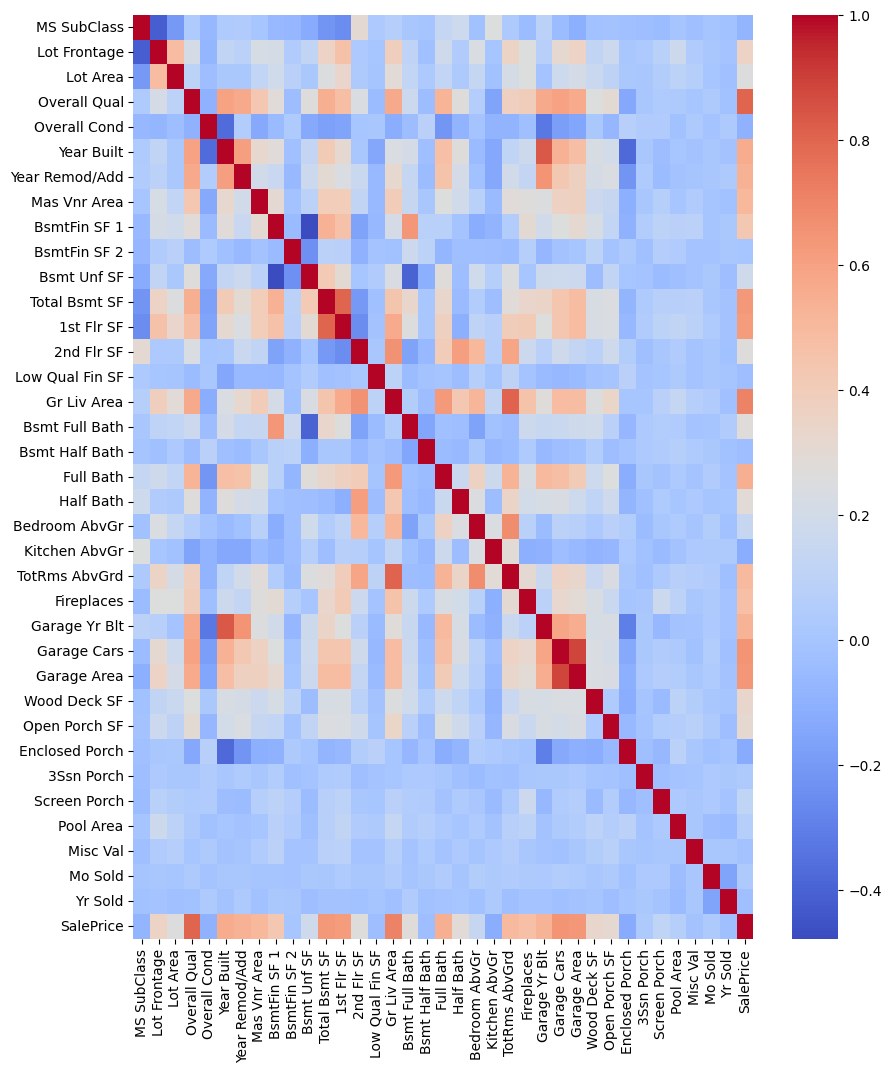

In [ ]:
# correlation plot
corr_mat = df.corr()

plt.figure(figsize=(10, 12))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', cbar=True)

plt.show()

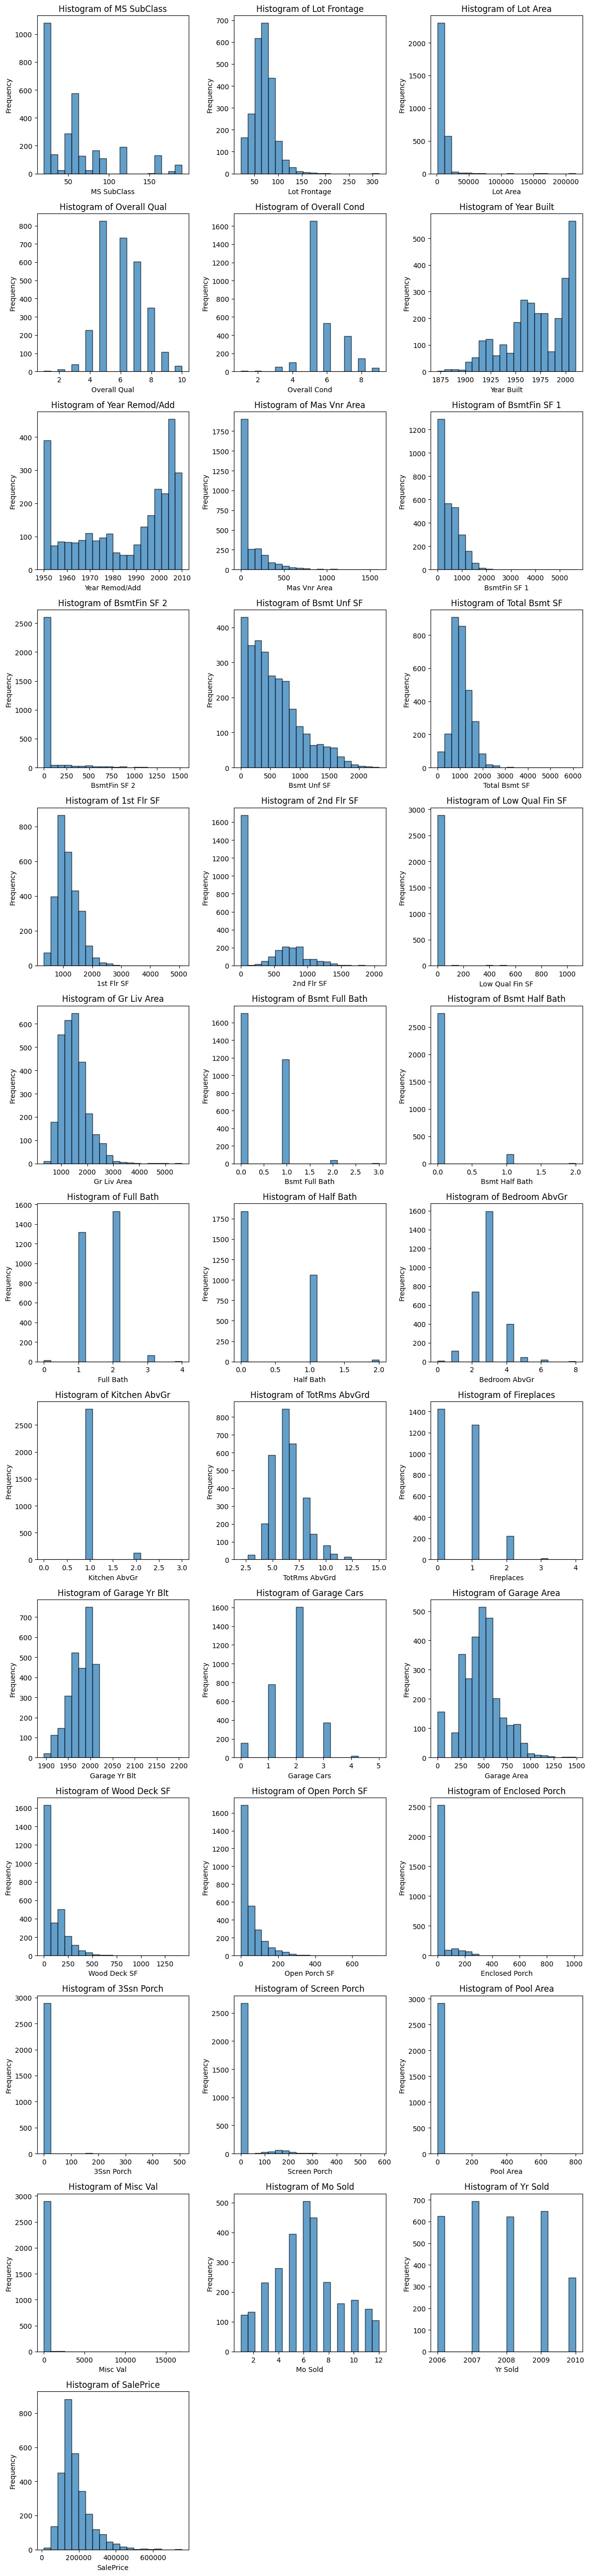

In [ ]:
# histograms of all variables

num_columns = len(df.columns)
num_rows = (num_columns // 3) + 1  # Adjust the number of rows for better layout

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot its histogram
for i, column in enumerate(df.columns):
    axes[i].hist(df[column], bins=20, edgecolor='black', alpha=0.7)  # Drop NaN values
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots if the number of columns is not a perfect multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# summarize duplicated information

df['Bathrooms'] = df['Full Bath'] + df['Half Bath']
df["Porch SF"] = df["3Ssn Porch"] + df["Enclosed Porch"] + df["Open Porch SF"] + df["Screen Porch"]
df["Total SF"] = df["1st Flr SF"] + df["2nd Flr SF"] + df["Low Qual Fin SF"]
df["Bsmt SF"] = df["BsmtFin SF 1"] + df["BsmtFin SF 2"] + df["Bsmt Unf SF"]


In [ ]:
# drop cols we don't want to use

df = df.drop(columns = ["Lot Frontage", "Mas Vnr Area", "BsmtFin SF 1",
    "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Bsmt Full Bath",
    "Bsmt Half Bath", "Garage Yr Blt", "Garage Cars",
    "Full Bath", "Half Bath", "Misc Val", "Kitchen AbvGr",
    "3Ssn Porch", "Enclosed Porch", "Open Porch SF", "Screen Porch",
    "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF"])

In [ ]:
# drop rows with NAs
df = df.dropna()

In [ ]:
# final numerical variables that we will use for clustering
df.columns

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Area', 'Wood Deck SF', 'Pool Area', 'Mo Sold',
       'Yr Sold', 'SalePrice', 'Bathrooms', 'Porch SF', 'Total SF', 'Bsmt SF'],
      dtype='object')

Final Numerical Variables Selected:


*   MS SubClass
*   Lot Area
*   Overall Qual
*   Overall Cond
*   Year Built
*   Year Remod/Add
*   Gr Liv Area
*   Bedroom AbvGr
*   TotRms AbvGrd
*   Fireplaces
*   Garage Area
*   Wood Deck SF
*   Pool Area
*   Mo Sold
*   Yr Sold
*   SalePrice
*   Bathrooms
*   Porch SF
*   Total SF
*   Bsmt SF

We first dropped the order and PID columns since they are unique identifiers and are not immeadiately relevant for clustering. We decided to do feature engineering and group columns together with their total sum to create new variables for total bathrooms, total square feet, basement square feet, and porch square feet. This allowed us to drop the original columns to prevent multicollinearity while retaining the relevant information we needed. We dropped kitchen above ground since we have total rooms above ground but we kept bedrooms above ground since that's a strong indicator for price. We dropped Misc Val since the histogram showed that most data points were binned into the same group so it may not have been helpful for clustering. We dropped lot frontage since about a quarter of the rows had missing data. Similarly, garage year built had a substantial amount of rows with missing data. Imputing or removing the rows with NAs for these two columns would potentially skew the data, therefore, we removed them. Since we kept garage area, we decided to drop garage cars as the large the area of the garage, the more cars there are. We decided to drop the few rows with NAs in our final set of variables since they make up a small portion of the data.




# Question 2: Scaling Data

In [ ]:
# splitting data into train and test 70-30 split
X_train, X_test = train_test_split(scaled_df, test_size=0.3, random_state=42)

In [ ]:
# Standard scaling using training set mean and std dev
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# convert back to pd dfs --> curr numpy arrays
X_train = pd.DataFrame(X_train, columns=df.columns)
X_test = pd.DataFrame(X_test, columns=df.columns)

In [ ]:
X_train.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Area,Wood Deck SF,Pool Area,Mo Sold,Yr Sold,SalePrice,Bathrooms,Porch SF,Total SF,Bsmt SF
1905,-0.877032,-0.069754,-0.776958,0.393655,-0.541829,-1.403826,-0.692046,-1.032367,-0.282335,-0.925730,-0.859865,-0.741964,-0.063053,1.393556,-0.600449,-0.461226,-1.176506,0.797207,-0.692046,0.059736
952,0.764655,-0.003138,-0.776958,-0.506128,0.185836,-0.348795,0.463393,1.383916,0.989474,-0.925730,0.307485,-0.741964,-0.063053,0.656635,0.918441,-0.686575,0.066659,-0.827436,0.463393,-2.386924
1047,2.406342,-0.995023,-0.068035,0.393655,0.119685,-0.444707,-0.086627,1.383916,0.353570,-0.925730,-0.059928,-0.741964,-0.063053,-0.448747,0.158996,-0.473746,1.309824,-0.827436,-0.086627,-0.446391
1711,-0.877032,-0.028389,0.640888,-0.506128,1.111956,1.041929,0.225974,0.175775,0.353570,-0.925730,1.884104,0.049410,-0.063053,-0.448747,-0.600449,0.811993,0.066659,-0.474656,0.225974,1.276257
2014,-0.173452,-0.496099,-0.776958,1.293437,-1.368722,0.370545,-0.145982,0.175775,-0.282335,0.617856,-1.129611,0.635026,-0.063053,0.288174,-0.600449,-0.614589,-1.176506,0.063797,-0.145982,-0.194463


In [ ]:
X_test.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Area,Wood Deck SF,Pool Area,Mo Sold,Yr Sold,SalePrice,Bathrooms,Porch SF,Total SF,Bsmt SF
2390,0.061075,0.344789,1.349811,-0.506128,1.111956,1.041929,1.490230,0.175775,0.989474,0.617856,0.474913,1.181074,-0.063053,0.288174,-1.359894,2.044312,1.309824,0.490846,1.490230,0.357057
196,-0.173452,-0.480872,-0.776958,0.393655,-0.971813,-1.643606,-0.092563,0.175775,0.353570,2.161442,-1.083103,-0.741964,-0.063053,-1.185667,1.677886,-0.611459,0.066659,0.871476,-0.092563,-0.491784
2307,-0.877032,0.200137,0.640888,0.393655,-0.078769,-0.732442,0.694877,0.175775,0.989474,0.617856,0.154008,-0.741964,-0.063053,-1.185667,-1.359894,0.140955,0.066659,0.527980,0.694877,1.814159
1731,0.061075,-0.053386,-0.068035,-0.506128,1.145031,1.089885,0.487135,0.175775,-0.282335,0.617856,-0.571516,-0.741964,-0.063053,-0.080286,-0.600449,0.220378,1.309824,-0.511791,0.487135,-0.802723
1100,0.061075,0.521545,1.349811,-0.506128,0.946577,0.754193,1.381413,1.383916,1.625379,0.617856,1.688771,0.777473,-0.063053,2.130476,0.158996,0.865826,1.309824,-0.047607,1.381413,0.211801


# Questions 3-6: K-Means

In [ ]:
def VAF_plot(df, k):
    df = df.to_numpy()
    vaf_df = []
    global_mean = np.mean(df, axis=0)  # global mean of all columns
    total_variance = np.sum((df - global_mean) ** 2)  # Total variance
    for i in range(1, k+1):
      x=KMeans(n_clusters=i, n_init=100, max_iter=1000, tol=0.0001,
               verbose=0,random_state = 42).fit(df)

      #centroids = x.cluster_centers_
      #labels = x.labels_

      inertia = x.inertia_
      vaf = (total_variance - inertia) / total_variance
      vaf_df.append(vaf)

    plt.figure(figsize=(6, 6))
    plt.plot(range(1, k + 1), vaf_df, marker='o')
    plt.title('Scree Plot')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('VAF')
    plt.xticks(range(1, k + 1))
    plt.grid()
    plt.show()

    return vaf_df


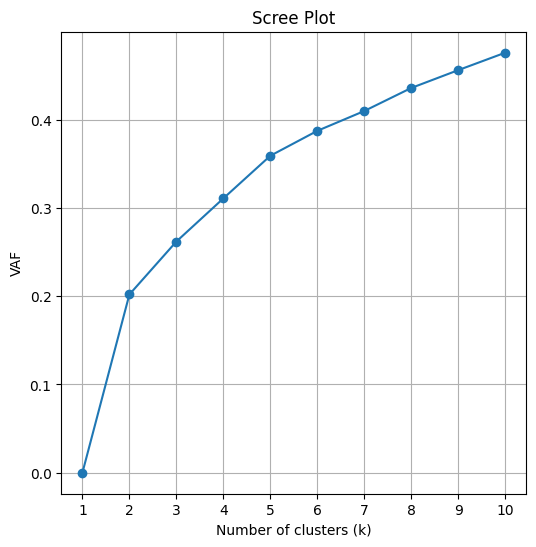

[1.7754899009720414e-16,
 0.20197863688668966,
 0.26196317109778255,
 0.3108449691930292,
 0.3591681402484469,
 0.38741536171577695,
 0.4098850333494153,
 0.4359996290257282,
 0.4562072806537074,
 0.4759670433203342]

In [ ]:
max_k = 10
VAF_plot(X_train, max_k)

In [ ]:
# Perform K-means clustering using K-opt
k_opt = 3 # Number of clusters
train_kmeans = KMeans(n_clusters=k_opt, n_init=100, max_iter=1000, tol=0.0001, verbose=0,random_state = 42)

train_kmeans.fit(df)

labels, centroids = train_kmeans.labels_, train_kmeans.cluster_centers_

The scree plot shows that k_opt can be 2, 3, or 4. When k=4, the VAF is higher than when k=2 or k=3, so we trained the model using k=2 and k=3. In the end, we found that the clusters were more interpretable in a business context when k_opt=3, therefore, this was our final pick.

In [ ]:
# Print cluster assignments and centroids
print("Cluster Assignments:")
print(labels)

Cluster Assignments:
[0 1 1 ... 1 1 0]


In [ ]:
# Initialize KMeans with the training centers
test_kmeans = KMeans(n_clusters= k_opt, init= centroids,
                     n_init=1, random_state=42)
test_labels = test_kmeans.fit_predict(X_test.to_numpy())

In [ ]:
# Rename columns
row_names = X_train.columns
centroids_transposed = centroids.T
centroids_df = pd.DataFrame(centroids_transposed, index=row_names)

# Add formatting for better readability
def format_dataframe(df):
    # Style the DataFrame for display
    styled_df = df.style.format(precision=0)  # No decimals for integers
    styled_df = styled_df.set_table_attributes('style="width:100%; border-collapse:collapse;"')  # Adjust width
    styled_df = styled_df.set_caption("Train Cluster Profiles")  # Add a caption

    return styled_df

# Format the DataFrame
formatted_centroids = format_dataframe(centroids_df)

# Display the styled DataFrame
formatted_centroids

,0,1,2
MS SubClass,56,59,48
Lot Area,11363,8773,14713
Overall Qual,7,5,9
Overall Cond,5,6,5
Year Built,1990,1956,2000
Year Remod/Add,1996,1975,2003
Gr Liv Area,1737,1248,2274
Bedroom AbvGr,3,3,3
TotRms AbvGrd,7,6,8
Fireplaces,1,0,1


In [ ]:
# Rename columns
row_names = X_test.columns
test_centroids = test_kmeans.cluster_centers_
centroids_transposed = test_centroids.T
centroids_df = pd.DataFrame(centroids_transposed, index=row_names)

# Add formatting for better readability
def format_dataframe(df):
    # Style the DataFrame for display
    styled_df = df.style.format(precision=0)  # No decimals for integers
    styled_df = styled_df.set_table_attributes('style="width:100%; border-collapse:collapse;"')  # Adjust width
    styled_df = styled_df.set_caption("Test Cluster Profiles")  # Add a caption

    return styled_df

# Format the DataFrame
formatted_centroids = format_dataframe(centroids_df)

# Display the styled DataFrame
formatted_centroids

,0,1,2
MS SubClass,0,-0,0
Lot Area,0,0,-0
Overall Qual,-0,1,-1
Overall Cond,0,-0,0
Year Built,-1,1,-0
Year Remod/Add,-1,1,-0
Gr Liv Area,0,1,-1
Bedroom AbvGr,1,0,-0
TotRms AbvGrd,1,1,-1
Fireplaces,0,0,-1


In [ ]:
print("Training Clusters:")
print("Cluster Size 0:", np.sum(labels == 0))
print("Cluster Proportion 0:", np.sum(labels == 0)/len(labels))
print("Cluster Size 1:", np.sum(labels == 1))
print("Cluster Proportion 1:", np.sum(labels == 1)/len(labels))
print("Cluster Size 2:", np.sum(labels == 2))
print("Cluster Proportion 2:", np.sum(labels == 2)/len(labels))

Training Clusters:
Cluster Size 0: 999
Cluster Proportion 0: 0.3411885245901639
Cluster Size 1: 1686
Cluster Proportion 1: 0.5758196721311475
Cluster Size 2: 243
Cluster Proportion 2: 0.08299180327868852


In [ ]:
print("Test Clusters:")
print("Cluster Size 0:", np.sum(test_labels == 0))
print("Cluster Proportion 0:", np.sum(test_labels == 0)/len(test_labels))
print("Cluster Size 1:", np.sum(test_labels == 1))
print("Cluster Proportion 1:", np.sum(test_labels == 1)/len(test_labels))
print("Cluster Size 2:", np.sum(test_labels == 2))
print("Cluster Proportion 2:", np.sum(test_labels == 2)/len(test_labels))

Test Clusters:
Cluster Size 0: 182
Cluster Proportion 0: 0.20705346985210465
Cluster Size 1: 328
Cluster Proportion 1: 0.3731513083048919
Cluster Size 2: 369
Cluster Proportion 2: 0.4197952218430034


In [ ]:
df = X_train.to_numpy()
global_mean = np.mean(df, axis=0)  # global mean of all columns
total_variance = np.sum((df - global_mean) ** 2)  # Total variance
inertia = train_kmeans.fit(df).inertia_
train_vaf = (total_variance - inertia) / total_variance

In [ ]:
df = X_test.to_numpy()
global_mean = np.mean(df, axis=0)  # global mean of all columns
total_variance = np.sum((df - global_mean) ** 2)  # Total variance
inertia = test_kmeans.fit(df).inertia_
test_vaf = (total_variance - inertia) / total_variance

In [ ]:
print("Train VAF:", train_vaf)
print("Test VAF:", test_vaf)

Train VAF: 0.26196317109778255
Test VAF: 0.2525505584508552


In the training phase, Cluster 1 was the largest, while in the testing phase, Cluster 2 had the highest size. This indicates that the cluster sizes and proportions were not consistent between the training and testing sets. However, despite this, the Variance Accounted For (VAF) remained stable across both sets, with the test set showing a slightly lower VAF. A notable issue is that the centroids in the test set do not correspond to the actual values that the final features can take. This discrepancy may arise due to the nature of KMeans clustering and when using it for testing.

# Questions 7-9: GMM

In [ ]:
#assign components 2-6
for cluster in range(2,7):

  mymixture = GaussianMixture(n_components=cluster,n_init=100,random_state=42)
  mixture_model = mymixture.fit(X_train)

  print("for cluster" + str(cluster))

  print("\n Mean")
  print(mixture_model.means_)
  print(mymixture.predict(X_train))
  print(mymixture.predict_proba(X_train))
  print("\n AIC score")
  print(mymixture.aic(X_train))
  print("\n BIC score")
  print(mymixture.bic(X_train))

for cluster2

 Mean
[[ 7.43888192e-02  4.06847964e+00  7.08828158e-01 -2.34816471e-01
   1.37263709e-01  4.23217245e-02  1.89421925e+00  4.05691729e-01
   9.42562835e-01  1.19169804e+00  1.17345251e+00  1.73469272e+00
   3.26142417e+00  8.97927194e-02 -5.82274723e-01  1.74051444e+00
   7.02210549e-01  7.95393275e-01  1.89421925e+00  1.33762012e+00]
 [-1.42275131e-03 -7.78132356e-02 -1.35569592e-02  4.49107062e-03
  -2.62528862e-03 -8.09440040e-04 -3.62286017e-02 -7.75920955e-03
  -1.80273396e-02 -2.27922686e-02 -2.24433068e-02 -3.31775173e-02
  -6.23775930e-02 -1.71736438e-03  1.11365139e-02 -3.32888628e-02
  -1.34303916e-02 -1.52125929e-02 -3.62286017e-02 -2.55831561e-02]]
[1 1 1 ... 1 1 1]
[[2.52012153e-12 1.00000000e+00]
 [2.22015372e-10 1.00000000e+00]
 [1.56671351e-11 1.00000000e+00]
 ...
 [2.15498926e-14 1.00000000e+00]
 [8.60920731e-15 1.00000000e+00]
 [2.54245471e-16 1.00000000e+00]]

 AIC score
36451.564773247315

 BIC score
39044.739168585445
for cluster3

 Mean
[[ 0.10468368

In [ ]:
#clusters = 5
final_mixture = GaussianMixture(n_components=5,n_init=100,random_state=42)
final_gmm_model = final_mixture.fit(X_train)

labels = final_mixture.predict(X_train)


Based on the AIC and BIC scores, we determined that 5 clusters were the optimal choice. The AIC score consistently decreased up to 5 clusters, after which it began to increase as additional clusters were added. Similarly, the BIC score decreased until 4 clusters but showed a slight increase for 5 clusters. This increase in BIC is likely due to its higher penalty for model complexity. Considering these factors, we selected 5 clusters, as it achieved the lowest AIC score.

In [ ]:
list_a = list(labels)
print(list_a)

[4, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 4, 4, 0, 0, 4, 1, 4, 2, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 4, 4, 1, 1, 2, 2, 1, 4, 0, 1, 4, 0, 4, 4, 4, 4, 4, 4, 4, 2, 1, 0, 2, 2, 2, 2, 2, 4, 4, 2, 2, 1, 4, 4, 2, 2, 1, 1, 4, 2, 4, 4, 2, 0, 2, 4, 0, 2, 2, 2, 2, 1, 2, 0, 0, 4, 4, 4, 0, 4, 4, 4, 1, 0, 0, 1, 1, 1, 1, 2, 4, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 4, 1, 4, 0, 4, 2, 2, 2, 0, 4, 2, 4, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 4, 0, 4, 4, 2, 2, 0, 2, 2, 0, 4, 2, 2, 2, 4, 0, 0, 1, 2, 3, 0, 2, 0, 4, 1, 4, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 4, 4, 1, 0, 1, 2, 1, 2, 4, 2, 2, 0, 2, 0, 4, 2, 4, 4, 0, 1, 2, 4, 4, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 4, 1, 2, 2, 0, 2, 1, 4, 4, 0, 0, 4, 4, 1, 1, 0, 4, 3, 0, 2, 0, 4, 4, 1, 1, 2, 0, 4, 4, 2, 4, 2, 2, 1, 4, 4, 4, 1, 2, 2, 1, 2, 1, 2, 1, 4, 0, 1, 2, 2, 0, 2, 0, 0, 0, 4, 1, 0, 1, 2, 0, 0, 2, 2, 0, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 1, 0, 2, 2, 2, 4, 4, 1, 2, 0, 0, 2, 2, 4, 2, 4, 1, 1, 2, 1, 0, 0, 4, 2, 1, 4, 4, 0, 2, 4, 0, 4, 4, 4, 2, 2, 2, 4, 0, 4, 4, 2, 0, 2, 0, 2, 2, 2, 4, 4, 

In [ ]:
scaled_gmm_means = scaler.inverse_transform(final_mixture.means_).T

In [ ]:
scaled_gmm_means

array([[ 6.49863268e+01,  5.82264006e+01,  6.22225682e+01,
         5.31065487e+01,  4.25556244e+01],
       [ 9.83223728e+03,  1.04381331e+04,  9.62482530e+03,
         4.42362544e+04,  8.44410374e+03],
       [ 5.70964012e+00,  5.62893008e+00,  7.28968179e+00,
         7.11849996e+00,  4.89504072e+00],
       [ 5.51404345e+00,  6.23629187e+00,  5.00000000e+00,
         5.41134769e+00,  5.93125884e+00],
       [ 1.97011099e+03,  1.94074780e+03,  2.00141012e+03,
         1.97299739e+03,  1.95142880e+03],
       [ 1.97011099e+03,  1.98041921e+03,  2.00179383e+03,
         1.98902243e+03,  1.97265290e+03],
       [ 1.43657516e+03,  1.62795460e+03,  1.72541735e+03,
         2.51556255e+03,  1.01719915e+03],
       [ 2.99946286e+00,  3.14940299e+00,  2.81384998e+00,
         3.14702919e+00,  2.49071533e+00],
       [ 6.35301621e+00,  6.99167553e+00,  6.85482690e+00,
         7.85375130e+00,  5.21382799e+00],
       [ 7.73043290e-01,  8.41320950e-01,  7.08507772e-01,
         1.49961505e+00

In [ ]:
row_names = X_train.columns
scaled_gmm_means = scaler.inverse_transform(final_mixture.means_)
gmm_df = pd.DataFrame(scaled_gmm_means, columns=row_names)


# Add formatting for better readability
def format_dataframe(df):
    # Style the DataFrame for display
    styled_df = df.style.format(precision=0)  # No decimals for integers
    styled_df = styled_df.set_table_attributes('style="width:100%; border-collapse:collapse;"')  # Adjust width
    styled_df = styled_df.set_caption("Cluster Profiles")  # Add a caption

    return styled_df

# Format the DataFrame
formatted_gmm = format_dataframe(gmm_df.T)

# Display the styled DataFrame
formatted_gmm

,0,1,2,3,4
MS SubClass,65,58,62,53,43
Lot Area,9832,10438,9625,44236,8444
Overall Qual,6,6,7,7,5
Overall Cond,6,6,5,5,6
Year Built,1970,1941,2001,1973,1951
Year Remod/Add,1970,1980,2002,1989,1973
Gr Liv Area,1437,1628,1725,2516,1017
Bedroom AbvGr,3,3,3,3,2
TotRms AbvGrd,6,7,7,8,5
Fireplaces,1,1,1,1,-0


# Question 8: Comparing GMM and KMeans

In [ ]:
# kmeans
formatted_centroids

,0,1,2
MS SubClass,0,-0,0
Lot Area,0,0,-0
Overall Qual,-0,1,-1
Overall Cond,0,-0,0
Year Built,-1,1,-0
Year Remod/Add,-1,1,-0
Gr Liv Area,0,1,-1
Bedroom AbvGr,1,0,-0
TotRms AbvGrd,1,1,-1
Fireplaces,0,0,-1


The centroid values for most features have similar ranges for both models, however, since the GMM has more clusters, the features have more segmentation and seperation between the clusters than the KMeans solution. The noticeable difference in centroid values between the two models occurs for pool area, where the KMeans solution has non-zero average values for all clusters but the GMM solution has zero for the first four clusters and 125 for the fifth cluster. Both models also had the same cluster centers for all clusters for year sold and month sold, with the values being 2007-2008 and 6-7 months respectively.

In terms of interpretability, the GMM model is easier to understand. Since the data has overlapping clusters, the GMM captures a more holistic representation of the clustering compared to KMeans. Additionally, since there are more clusters found at the optimal GMM for this dataset, the clusters are more differentiable compared to the three clusters returned by the KMeans solution, allowing for easier cluster profiling.

# Question 9: Cluster Profiling

Since the GMM is more interpretable, we will use that model as our final model. The clusters can be profiled as:

*   Cluster 0: Mid-Range Family Homes
*   Cluster 1: Large, Well-Rounded Homes
*   Cluster 2: Modern, Mid-Size Homes
*   Cluster 3: Luxury, Spacious Homes
*   Cluster 4: Compact, Older Homes

This clustering analysis provides valuable insights for real estate professionals, sellers, and online real estate platforms like Zillow by enabling more targeted marketing, pricing strategies, and personalized recommendations. Here's a detailed description and differentiators for each cluster, along with insights on how these clusters can have a direct business impact.

**Cluster 0: Mid-Range Family Homes**

These homes are practical, moderately priced, and designed for middle-income families. With an average sale price of $158,237, they feature 3 bedrooms, 2 bathrooms, and a balanced living area of 1,437 sq. ft. They have additional features like a fireplace and a porch but lack modern upgrades, built around the 1970s.

* Key Difference: Offer functional layouts and affordability compared to other clusters.
* Business Strategy: Perfect for targeting first-time buyers or young families. Marketing should emphasize affordability, functionality, and family-friendly features. Online real estate platforms can recommend these homes to buyers with moderate budgets and family-focused searches.

**Cluster 1: Large, Well-Rounded Homes**

Built in the 1940s and remodeled in the 1980s, they have spacious layouts with 7 rooms and higher total square footage (1,628 sq. ft.). They also have a larger lot area (10,438 sq. ft.) and larger porch area (119 sq. ft), balancing space, and price appealing to families wanting more room at a budget, priced similarly to Cluster 0 at $158,601.

* Key Difference: Larger than Cluster 0 at a similar price but older and less modern.
* Business Strategy: Market these homes to families seeking larger homes at mid-tier prices. Sellers can highlight remodeling potential, while online real estate platforms can target buyers prioritizing size and flexibility over modern features.

**Cluster 2: Modern, Mid-Size Homes**

With a more recent construction year (2001) and higher quality score, these homes combine modern amenities with mid-size layouts. They feature 7 rooms, 3 bedrooms, and 3 bathrooms, and a living area of 1,725 sq. ft. Given the modern amenities, they sell at a higher price of around $238,711.

* Key Difference: Stand out for their newer construction, superior quality and higher price tag compared to Clusters 0 and 1.
* Business Strategy: Attract modern buyers and young professionals seeking contemporary homes. Emphasize the newer design, high-quality construction, and upgraded features. Online real estate platforms can recommend these homes to buyers looking for modernity at a reasonable price.

**Cluster 3: Luxury, Spacious Homes**

These high-end homes cater to affluent buyers, featuring expansive living areas (2,516 sq. ft.) and a sprawling lot size (44,236 sq. ft.), with premium amenities like pools and large decks. They were built around the 1970s and remodeled in the 1980s. They sell for $312,129.

* Key Difference: Defined by luxury, space, and premium amenities compared to other clusters.
* Business Strategy: Target high-income buyers or those searching for exclusivity. Marketing should highlight luxury features, such as pools and large decks, while online real estate platforms can promote these to users with high budgets or preferences for premium properties.

**Cluster 4: Compact, Older Homes**


These smaller, budget-friendly homes appeal to price-conscious buyers or investors. Built in the 1950s, they are compact with a small living area (1,017 sq. ft.) and fewer amenities (no fireplace and small porch) but offer affordability at an average price of $117,649.

* Key Difference: The smallest, least expensive, and most basic homes compared to other clusters.
* Business Strategy: Position these as ideal for first-time buyers, retirees, or investors. Marketing can highlight their potential for renovation or customization. Zillow can suggest these to users with tight budgets or those searching for smaller, low-maintenance homes.